In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3
import mysql.connector as cnt
import plotly.express as px
import requests
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import os
import selenium
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from bs4 import BeautifulSoup
import time
from matplotlib.patches import ConnectionPatch

In [2]:
SDB = sqlite3.connect('aruodas3.db') # jei neegsiztuoja - bus sukurfta nauja sqlite DB
Cs = SDB.cursor()

sql="""SELECT * FROM aruododuomenys;"""
Cs.execute(sql)
ans = Cs.fetchall()
# gamintojas, modelis, kaina, metai, kebulas, kuras, pavaros, galingumas, rida, nuorodos, pirmaregistracija, technikine = list(map(list, zip(*ans)))

df = pd.read_sql_query(sql, con=SDB)
df.head(3)

,plotas,kambariuskaicius,aukstas,aukstuskaicius,metai,pastatotipas,sildymas,irengimas,energetineklase,ilguma,platuma,miestas,kaina,rajonas
0,"34,93 m²",2,5,5,2023,Mūrinis,Centrinis kolektorinis,Įrengtas,None,54.701257,25.272667,Vilnius,173500,Šnipiškės
1,"66,64 m²",2,3,5,2003,Mūrinis,Centrinis,Įrengtas,A,54.705467,25.286944,Vilnius,205000,Žirmūnai
2,"66,89 m²",3,2,9,1980,Blokinis,Centrinis,Įrengtas,None,54.717923,25.238122,Vilnius,172000,Šeškinė


In [3]:
df['plotas']=df['plotas'].str.replace('m²', '')
df['plotas'] = df['plotas'].str.replace(',','.').astype(float)

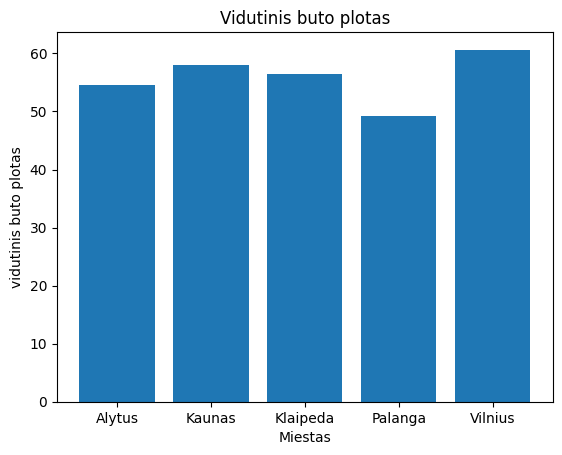

In [4]:
# vidutinis plotas

vidplotasDF = df.groupby('miestas')['plotas'].mean().reset_index()

fig, axis = plt.subplots()

axis.bar(vidplotasDF['miestas'], vidplotasDF['plotas'])
axis.set_xticks(vidplotasDF['miestas'])
# axis.set_xticklabels(dfrida['ridosintervalai'], rotation=45)

axis.set_xlabel('Miestas')
axis.set_ylabel('vidutinis buto plotas')
plt.title('Vidutinis buto plotas')

# plt.tight_layout()
plt.show()

In [5]:
# plotai po 5 m2

df['plotointervalai'] = np.ceil(df['plotas'] / 5) * 5


In [6]:

# dažniausiai pasikartojantys plotai
most_common_sizes = df.groupby('miestas')['plotointervalai'].agg(lambda x: x.mode().iloc[0])

most_common_sizes

miestas
Alytus      65.0
Kaunas      45.0
Klaipeda    50.0
Palanga     40.0
Vilnius     50.0
Name: plotointervalai, dtype: float64

In [7]:
df['metai'] = df['metai'].replace('None', np.nan)

df['amzius'] = df['metai'].apply(lambda x: 2024 - int(x) if pd.notnull(x) else None)

df.head()

,plotas,kambariuskaicius,aukstas,aukstuskaicius,metai,pastatotipas,sildymas,irengimas,energetineklase,ilguma,platuma,miestas,kaina,rajonas,plotointervalai,amzius
0,34.93,2,5,5,2023.0,Mūrinis,Centrinis kolektorinis,Įrengtas,None,54.701257,25.272667,Vilnius,173500,Šnipiškės,35.0,1.0
1,66.64,2,3,5,2003.0,Mūrinis,Centrinis,Įrengtas,A,54.705467,25.286944,Vilnius,205000,Žirmūnai,70.0,21.0
2,66.89,3,2,9,1980.0,Blokinis,Centrinis,Įrengtas,None,54.717923,25.238122,Vilnius,172000,Šeškinė,70.0,44.0
3,98.00,3,2,5,2008.0,Mūrinis,Centrinis,Įrengtas,A+,54.691637,25.284638,Vilnius,615000,Šnipiškės,100.0,16.0
4,46.23,3,3,5,1969.0,Blokinis,Centrinis,Įrengtas,D,54.707286,25.286241,Vilnius,147500,Šnipiškės,50.0,55.0


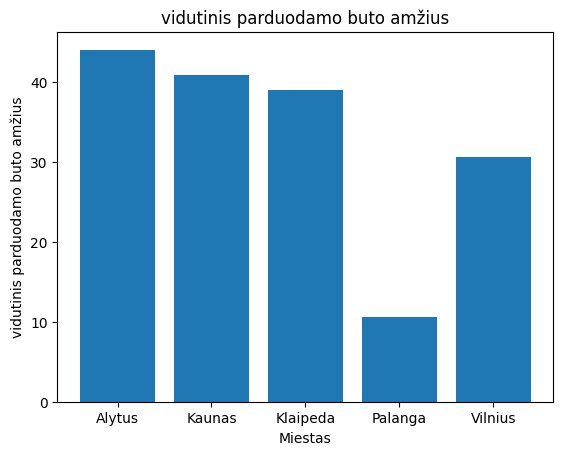

In [8]:
# Koks vidutinis amžius/statybos metai NT objektų

vidamziusDF = df.groupby('miestas')['amzius'].mean().reset_index()

fig, axis = plt.subplots()

axis.bar(vidamziusDF['miestas'], vidamziusDF['amzius'])
axis.set_xticks(vidamziusDF['miestas'])
# axis.set_xticklabels(dfrida['ridosintervalai'], rotation=45)

axis.set_xlabel('Miestas')
axis.set_ylabel('vidutinis parduodamo buto amžius')
plt.title('vidutinis parduodamo buto amžius')

# plt.tight_layout()
plt.show()

In [9]:
df['m2kaina']=round(df['kaina'] / df['plotas'], 1)

df.head()

,plotas,kambariuskaicius,aukstas,aukstuskaicius,metai,pastatotipas,sildymas,irengimas,energetineklase,ilguma,platuma,miestas,kaina,rajonas,plotointervalai,amzius,m2kaina
0,34.93,2,5,5,2023.0,Mūrinis,Centrinis kolektorinis,Įrengtas,None,54.701257,25.272667,Vilnius,173500,Šnipiškės,35.0,1.0,4967.1
1,66.64,2,3,5,2003.0,Mūrinis,Centrinis,Įrengtas,A,54.705467,25.286944,Vilnius,205000,Žirmūnai,70.0,21.0,3076.2
2,66.89,3,2,9,1980.0,Blokinis,Centrinis,Įrengtas,None,54.717923,25.238122,Vilnius,172000,Šeškinė,70.0,44.0,2571.4
3,98.00,3,2,5,2008.0,Mūrinis,Centrinis,Įrengtas,A+,54.691637,25.284638,Vilnius,615000,Šnipiškės,100.0,16.0,6275.5
4,46.23,3,3,5,1969.0,Blokinis,Centrinis,Įrengtas,D,54.707286,25.286241,Vilnius,147500,Šnipiškės,50.0,55.0,3190.6


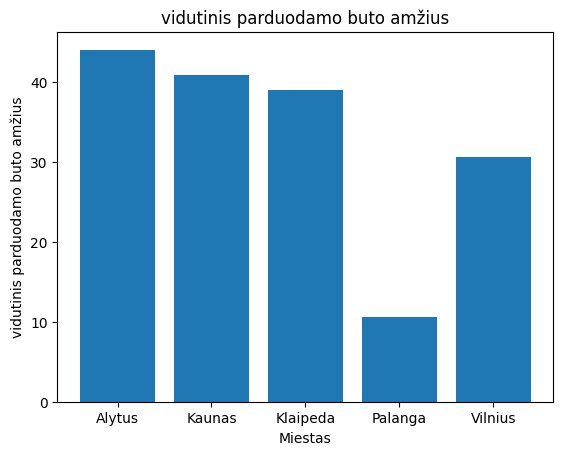

In [10]:
# Koks vidutinis amžius/statybos metai NT objektų

vidamziusDF = df.groupby('miestas')['amzius'].mean().reset_index()

fig, axis = plt.subplots()

axis.bar(vidamziusDF['miestas'], vidamziusDF['amzius'])
axis.set_xticks(vidamziusDF['miestas'])
# axis.set_xticklabels(dfrida['ridosintervalai'], rotation=45)

axis.set_xlabel('Miestas')
axis.set_ylabel('vidutinis parduodamo buto amžius')
plt.title('vidutinis parduodamo buto amžius')

# plt.tight_layout()
plt.show()

In [11]:
df['energetineklase'] = df['energetineklase'].replace('None', 'nenurodyta')
df['energetineklase'] = df['energetineklase'].fillna('nenurodyta')
df.head(10)

,plotas,kambariuskaicius,aukstas,aukstuskaicius,metai,pastatotipas,sildymas,irengimas,energetineklase,ilguma,platuma,miestas,kaina,rajonas,plotointervalai,amzius,m2kaina
0,34.93,2,5,5,2023.0,Mūrinis,Centrinis kolektorinis,Įrengtas,nenurodyta,54.701257,25.272667,Vilnius,173500,Šnipiškės,35.0,1.0,4967.1
1,66.64,2,3,5,2003.0,Mūrinis,Centrinis,Įrengtas,A,54.705467,25.286944,Vilnius,205000,Žirmūnai,70.0,21.0,3076.2
2,66.89,3,2,9,1980.0,Blokinis,Centrinis,Įrengtas,nenurodyta,54.717923,25.238122,Vilnius,172000,Šeškinė,70.0,44.0,2571.4
3,98.00,3,2,5,2008.0,Mūrinis,Centrinis,Įrengtas,A+,54.691637,25.284638,Vilnius,615000,Šnipiškės,100.0,16.0,6275.5
4,46.23,3,3,5,1969.0,Blokinis,Centrinis,Įrengtas,D,54.707286,25.286241,Vilnius,147500,Šnipiškės,50.0,55.0,3190.6
5,56.00,2,4,4,NaN,Mūrinis,Aeroterminis,Įrengtas,nenurodyta,54.680225,25.281521,Vilnius,325000,Senamiestis,60.0,NaN,5803.6
6,80.13,4,2,9,2020.0,Mūrinis,Centrinis kolektorinis,Įrengtas,B,54.738766,25.223195,Vilnius,195000,Pašilaičiai,85.0,4.0,2433.5
7,113.00,4,1,2,2024.0,Mūrinis,Elektra,Dalinė apdaila,A++,54.712883,25.161247,Vilnius,188700,Pilaitė,115.0,0.0,1669.9
8,54.72,3,3,6,2022.0,Mūrinis,Centrinis kolektorinis,Įrengtas,A+,54.738780,25.214851,Vilnius,178000,Pašilaičiai,55.0,2.0,3252.9
9,84.37,3,6,6,2016.0,Mūrinis,Centrinis kolektorinis,Įrengtas,nenurodyta,54.725691,25.320996,Vilnius,485000,Antakalnis,85.0,8.0,5748.5


In [12]:
# pagal energerinę klasę

energklaseDF= round(df.groupby('energetineklase')['m2kaina'].mean().reset_index(), 0 )


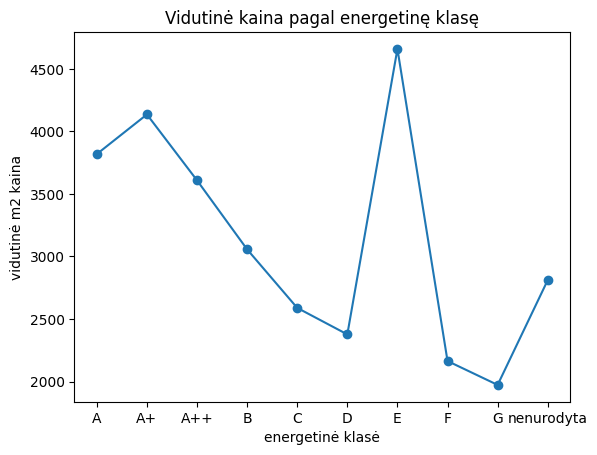

In [13]:
fig, axis = plt.subplots()

axis.plot(energklaseDF['energetineklase'], energklaseDF['m2kaina'], marker ='o')
axis.set_xticks(energklaseDF['energetineklase'])
axis.set_xlabel('energetinė klasė')
axis.set_ylabel('vidutinė m2 kaina')
plt.title('Vidutinė kaina pagal energetinę klasę')

plt.show()

In [14]:
sildymasDF= round(df.groupby('sildymas')['m2kaina'].mean().reset_index(), 0 ).sort_values(by='m2kaina', ascending=False)

sildymasDF.head(50)

,sildymas,m2kaina
29,"Centrinis, geoterminis",9375.0
12,"Centrinis kolektorinis, geoterminis",7418.0
13,"Centrinis kolektorinis, geoterminis, kietu kuru",6500.0
25,"Centrinis, elektra, centrinis kolektorinis, ae...",5150.0
37,"Dujinis, elektra, saulės energija",4649.0
31,"Centrinis, kita",4504.0
19,"Centrinis, centrinis kolektorinis, dujinis",4310.0
56,Geoterminis,4299.0
15,"Centrinis kolektorinis, kita",4276.0
48,"Elektra, dujinis, kita",4190.0


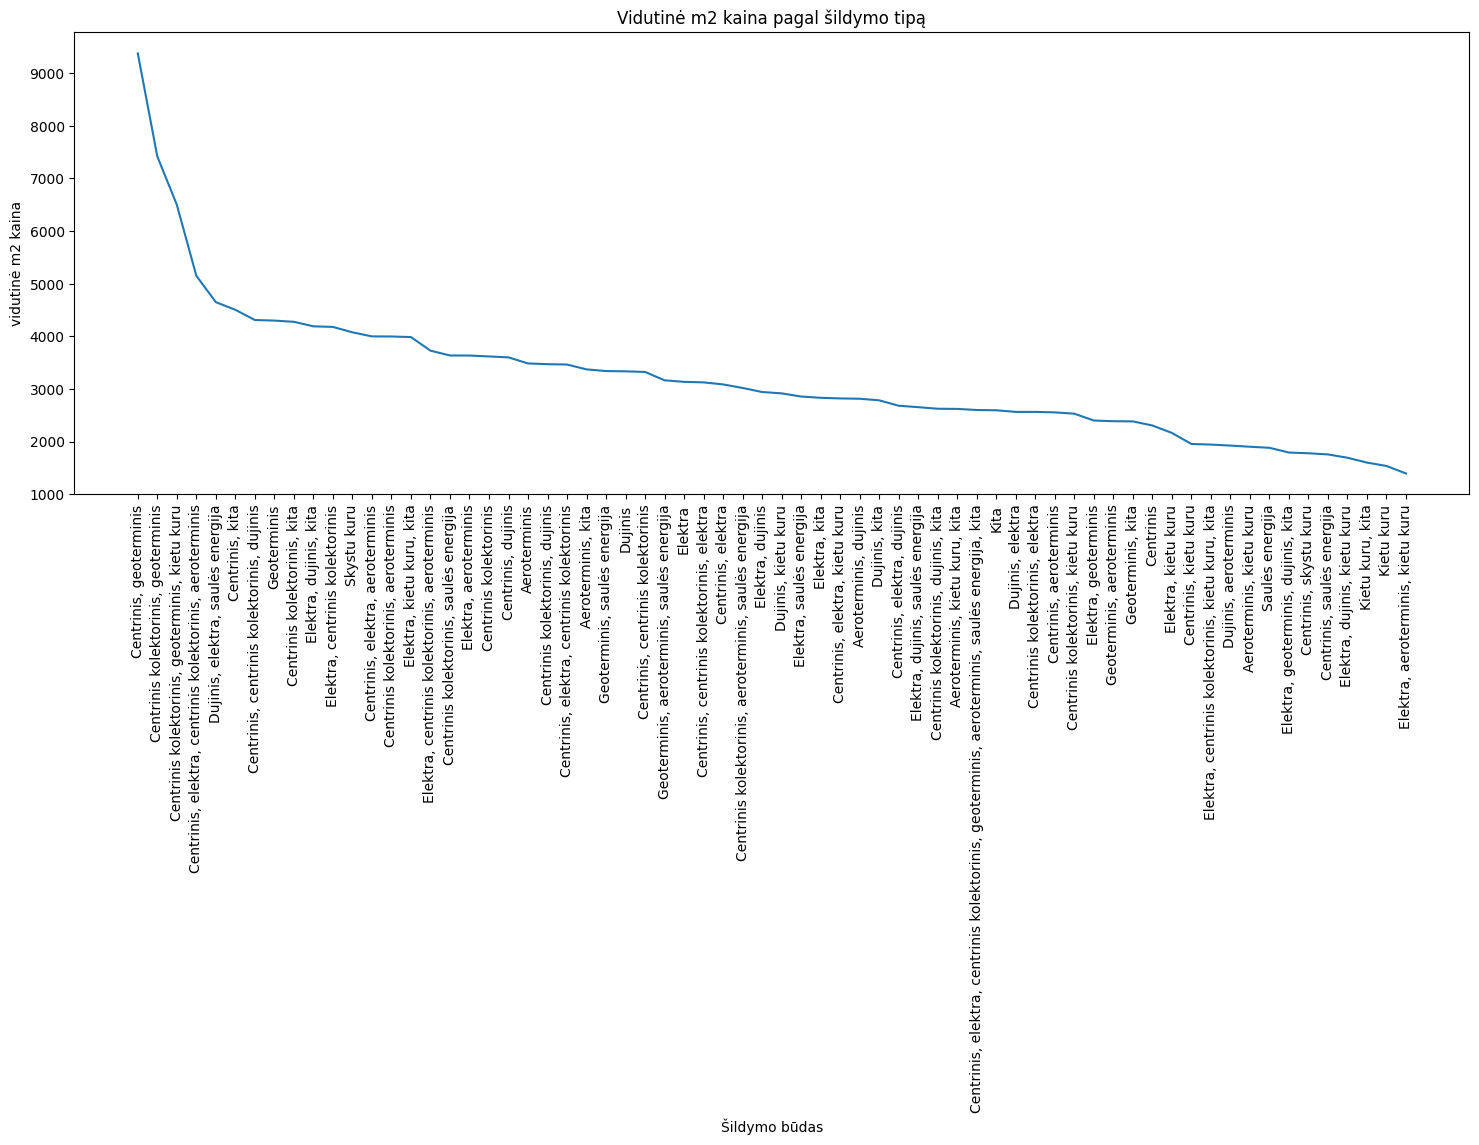

In [15]:
fig, axis = plt.subplots(figsize=(18, 6))

axis.plot(sildymasDF['sildymas'], sildymasDF['m2kaina'])
axis.set_xticks(sildymasDF['sildymas'])
axis.set_xlabel('Šildymo būdas')
axis.set_ylabel('vidutinė m2 kaina')
plt.title('Vidutinė m2 kaina pagal šildymo tipą')
# axis.set_xlim(left=0, right=26)
plt.xticks(rotation=90)

# plt.tight_layout()
plt.show()

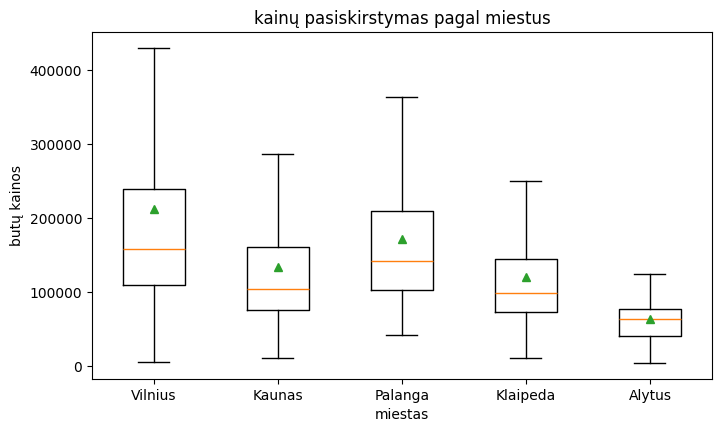

In [16]:
kainos=[]

miestai = df['miestas'].unique()

for i in range(len(miestai)):
    rid=(df[df['miestas'] == miestai[i]]['kaina'].tolist()) 
    rid= [value for value in rid if value is not None]
    rid = [value for value in rid if pd.notna(value)]
    rid = [float(value) for value in rid]
    kainos.append(rid)
    
fig, axis = plt.subplots(figsize=[8,4.5])
axis.boxplot(kainos, showmeans=True, showfliers=False)
axis.set_xticklabels(miestai)
plt.title('kainų pasiskirstymas pagal miestus')
plt.xlabel('miestas')
plt.ylabel('butų kainos')
plt.show()



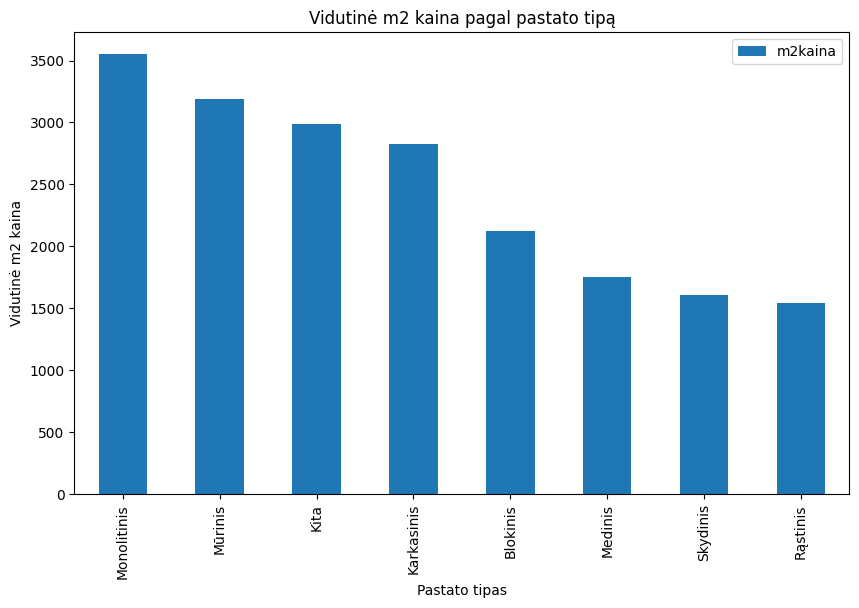

In [17]:
pastatotipasDF= df.groupby('pastatotipas')['m2kaina'].mean().reset_index().round(0).sort_values(by='m2kaina', ascending=False)

ax = pastatotipasDF.plot(x='pastatotipas', y='m2kaina', kind='bar', figsize=(10, 6))

ax.set_xlabel('Pastato tipas')
ax.set_ylabel('Vidutinė m2 kaina')
plt.title('Vidutinė m2 kaina pagal pastato tipą')

plt.show()

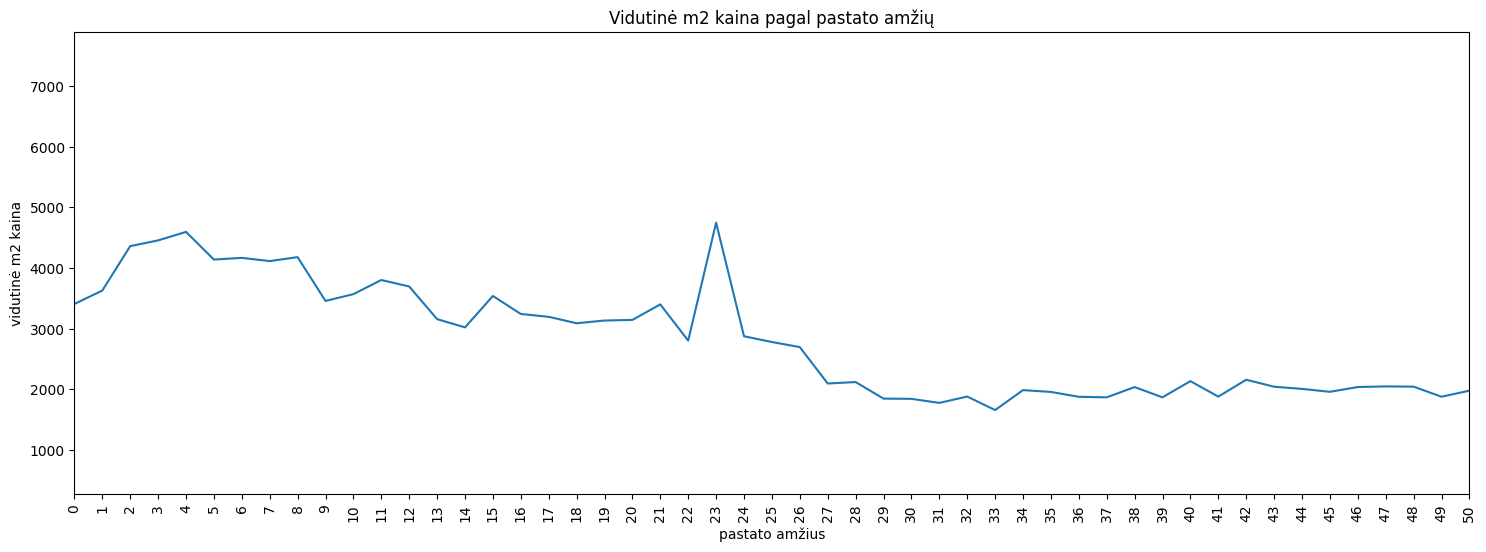

In [18]:
amziusDF= df.groupby('amzius')['m2kaina'].mean().reset_index().round(0).sort_values(by='amzius', ascending=False)

fig, axis = plt.subplots(figsize=(18, 6))

axis.plot(amziusDF['amzius'], amziusDF['m2kaina'])
axis.set_xticks(amziusDF['amzius'])
axis.set_xlabel('pastato amžius')
axis.set_ylabel('vidutinė m2 kaina')
plt.title('Vidutinė m2 kaina pagal pastato amžių')
axis.set_xlim(left=0, right=50)
plt.xticks(rotation=90)

# plt.tight_layout()
plt.show()

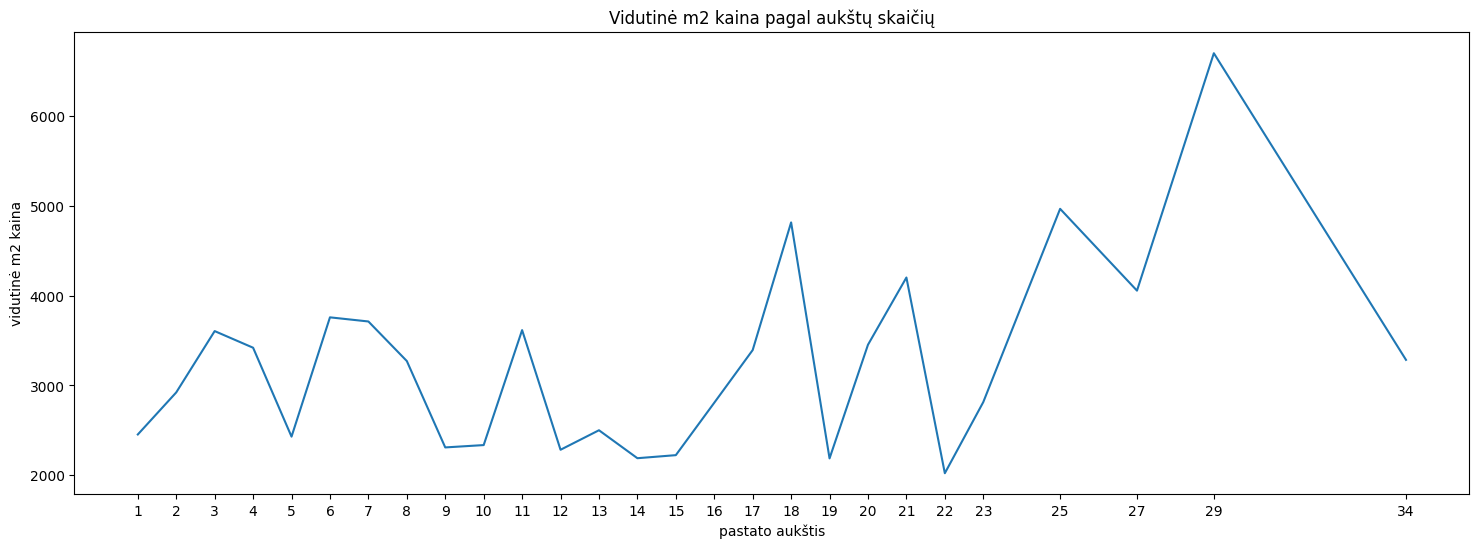

In [19]:
aukstuskDF= df.groupby('aukstuskaicius')['m2kaina'].mean().reset_index().round(0).sort_values(by='aukstuskaicius', ascending=False)

fig, axis = plt.subplots(figsize=(18, 6))

axis.plot(aukstuskDF['aukstuskaicius'], aukstuskDF['m2kaina'])
axis.set_xticks(aukstuskDF['aukstuskaicius'])
axis.set_xlabel('pastato aukštis')
axis.set_ylabel('vidutinė m2 kaina')
plt.title('Vidutinė m2 kaina pagal aukštų skaičių')
# axis.set_xlim(left=0, right=50)
# plt.xticks(rotation=90)

# plt.tight_layout()
plt.show()

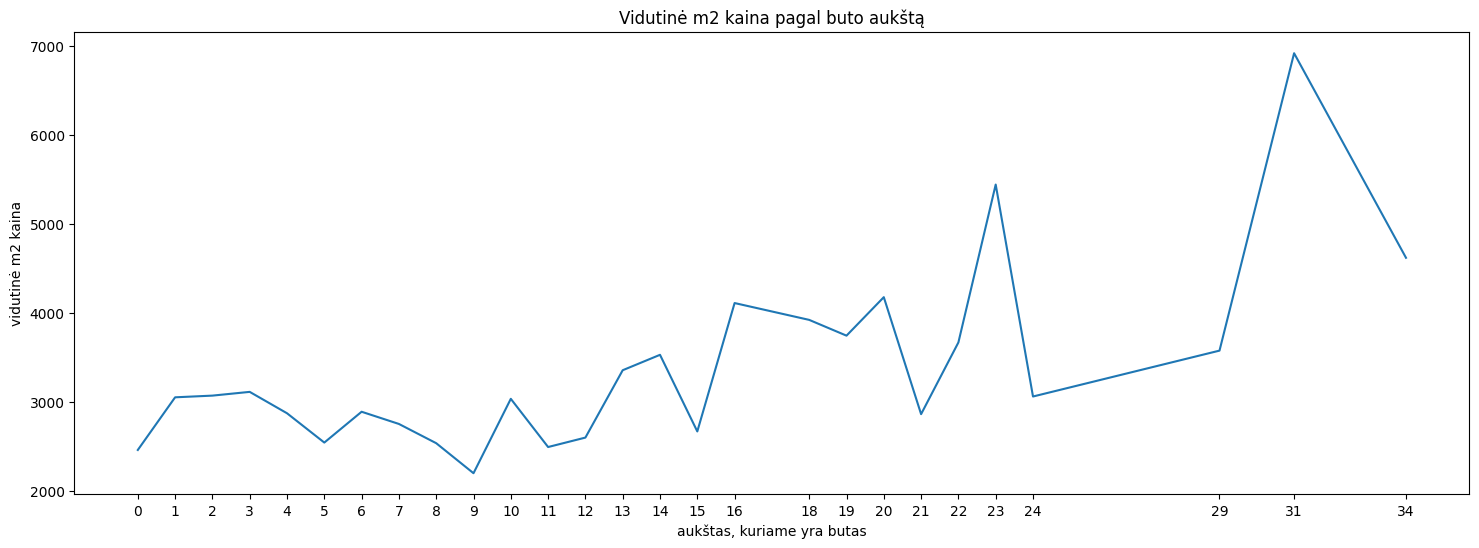

In [20]:
aukstasDF= df.groupby('aukstas')['m2kaina'].mean().reset_index().round(0).sort_values(by='aukstas', ascending=False)

fig, axis = plt.subplots(figsize=(18, 6))

axis.plot(aukstasDF['aukstas'], aukstasDF['m2kaina'])
axis.set_xticks(aukstasDF['aukstas'])
axis.set_xlabel('aukštas, kuriame yra butas')
axis.set_ylabel('vidutinė m2 kaina')
plt.title('Vidutinė m2 kaina pagal buto aukštą')
# axis.set_xlim(left=0, right=50)
# plt.xticks(rotation=90)

# plt.tight_layout()
plt.show()

In [21]:
vilniusDF = df.query('miestas == "Vilnius"')

In [22]:
vilniusVIDkainaDF=vilniusDF.groupby('rajonas')['kaina'].mean().reset_index().round(0).sort_values(by='kaina', ascending=False)
vilniusbutukiekisDF= vilniusDF['rajonas'].value_counts().reset_index().sort_values(by='count', ascending=False)
vilniusamziusDF= vilniusDF.groupby('rajonas')['amzius'].mean().reset_index().round(0).sort_values(by='amzius', ascending=False)


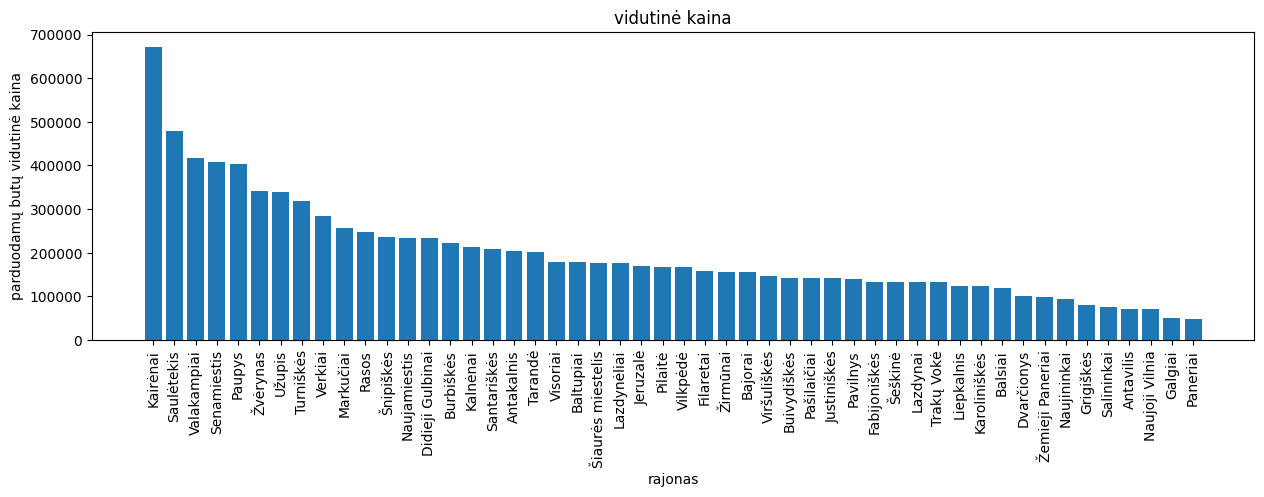

In [23]:
fig, axis = plt.subplots(figsize=(15, 4))

axis.bar(vilniusVIDkainaDF['rajonas'], vilniusVIDkainaDF['kaina'])
axis.set_xticks(vilniusVIDkainaDF['rajonas'])
# axis.set_xticklabels(dfrida['ridosintervalai'], rotation=45)

axis.set_xlabel('rajonas')
axis.set_ylabel('parduodamų butų vidutinė kaina')
plt.title('vidutinė kaina')
plt.xticks(rotation=90)

# plt.tight_layout()
plt.show()

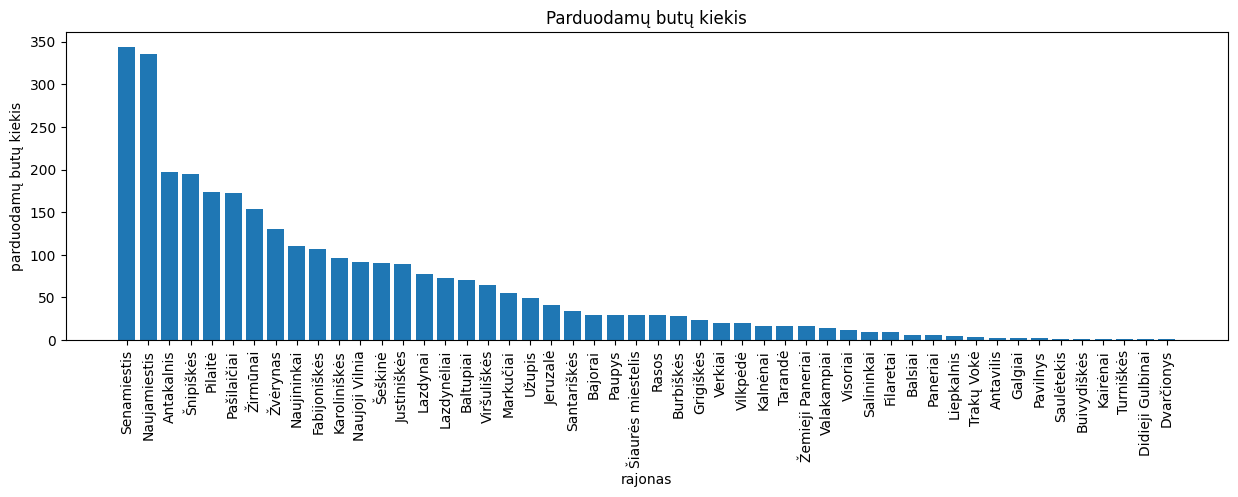

In [24]:
fig, axis = plt.subplots(figsize=(15, 4))

axis.bar(vilniusbutukiekisDF['rajonas'], vilniusbutukiekisDF['count'])
axis.set_xticks(vilniusbutukiekisDF['rajonas'])
# axis.set_xticklabels(dfrida['ridosintervalai'], rotation=45)

axis.set_xlabel('rajonas')
axis.set_ylabel('parduodamų butų kiekis')
plt.title('Parduodamų butų kiekis')
plt.xticks(rotation=90)

# plt.tight_layout()
plt.show()

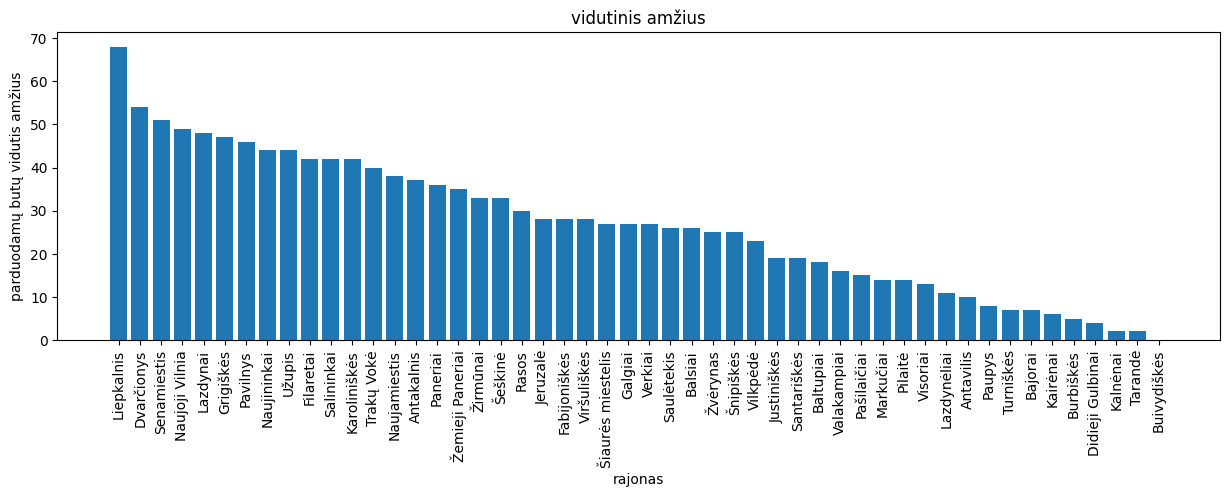

In [25]:
fig, axis = plt.subplots(figsize=(15, 4))

axis.bar(vilniusamziusDF['rajonas'], vilniusamziusDF['amzius'])
axis.set_xticks(vilniusamziusDF['rajonas'])
# axis.set_xticklabels(dfrida['ridosintervalai'], rotation=45)

axis.set_xlabel('rajonas')
axis.set_ylabel('parduodamų butų vidutis amžius')
plt.title('vidutinis amžius')
plt.xticks(rotation=90)

# plt.tight_layout()
plt.show()

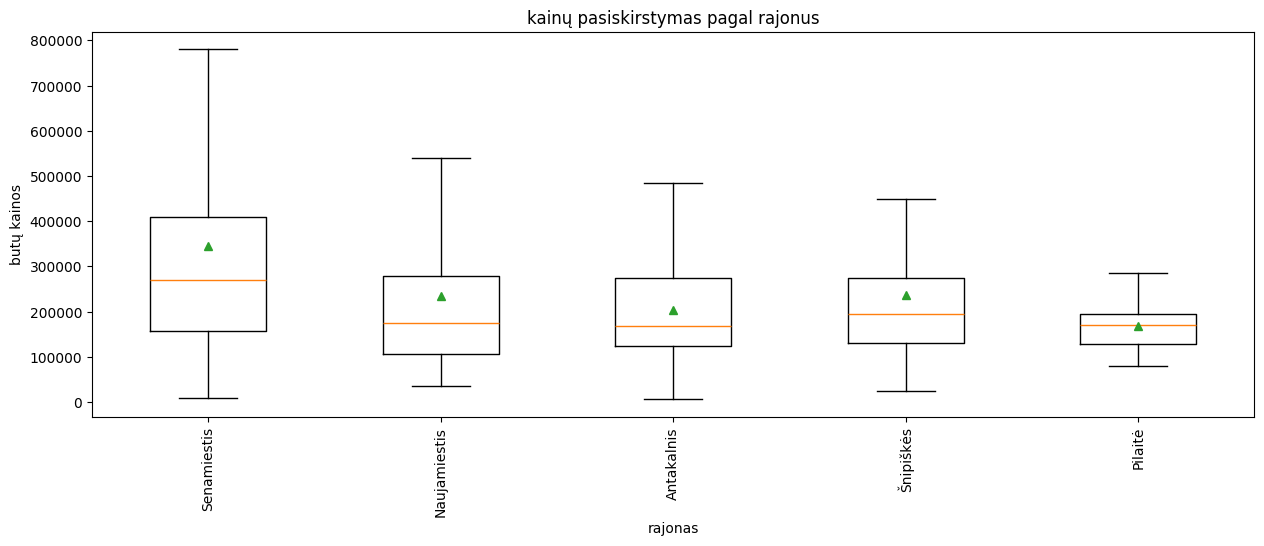

In [26]:
topkiekisDF=vilniusbutukiekisDF.head(5)

kainos=[]

rajonai = topkiekisDF['rajonas'].unique()

for i in range(len(rajonai)):
    rid=(df[df['rajonas'] == rajonai[i]]['kaina'].tolist()) 
    rid= [value for value in rid if value is not None]
    rid = [value for value in rid if pd.notna(value)]
    rid = [float(value) for value in rid]
    kainos.append(rid)
    
fig, axis = plt.subplots(figsize=[15, 5])
axis.boxplot(kainos, showmeans=True, showfliers=False)
axis.set_xticklabels(rajonai)
plt.title('kainų pasiskirstymas pagal rajonus')
plt.xlabel('rajonas')
plt.ylabel('butų kainos')
plt.xticks(rotation=90)
plt.show()

In [27]:
# Create a scatter mapbox plot
fig = px.scatter_mapbox(
    vilniusDF,
    lat='ilguma',
    lon='platuma',
    hover_name='kaina',
    # size='size',  # Adjust marker size based on a column
    size_max=15,  # Maximum size for the markers
    color='rajonas',  # Color markers based on the 'size' column
    color_continuous_scale=px.colors.sequential.Plasma,  # Color scale
    mapbox_style='carto-positron',  # Choose a Mapbox style
    zoom=10,  # Zoom level
    center={"lat": 54.6880, "lon": 25.2795}  # Center the map
)

# Show the figure
fig.show()

In [28]:
vilniusbutukiekisDF.head()

,rajonas,count
0,Senamiestis,344
1,Naujamiestis,335
2,Antakalnis,197
3,Šnipiškės,195
4,Pilaitė,174


In [29]:
platumadDF=df.groupby('rajonas')['platuma'].mean().reset_index()
ilgumaDF=df.groupby('rajonas')['ilguma'].mean().reset_index()
rajonokoordDF = pd.merge(vilniusbutukiekisDF, platumadDF, on='rajonas', how='inner')
rajonokoordDF = pd.merge(rajonokoordDF, ilgumaDF, on='rajonas', how='inner')

rajonokoordDF = pd.merge(rajonokoordDF, vilniusVIDkainaDF, on='rajonas', how='inner')
rajonokoordDF = rajonokoordDF[rajonokoordDF['count'] >= 10]
rajonokoordDF.loc[rajonokoordDF['rajonas'] == 'Senamiestis', ['platuma', 'ilguma']] = [25.286291, 54.684590]


rajonokoordDF.head()

,rajonas,count,platuma,ilguma,kaina
0,Senamiestis,344,25.286291,54.684590,406896.0
1,Naujamiestis,335,25.261117,54.675707,234554.0
2,Antakalnis,197,25.327959,54.712597,204719.0
3,Šnipiškės,195,25.280918,54.701965,236460.0
4,Pilaitė,174,25.178209,54.708964,168102.0


In [30]:
# Create a scatter mapbox plot
fig = px.scatter_mapbox(
    rajonokoordDF,
    lat='ilguma',
    lon='platuma',
    hover_name='rajonas',
    size='count',  # Adjust marker size based on a column
    size_max=40,  # Maximum size for the markers
    color='kaina',  # Color markers based on the 'size' column
    color_continuous_scale=px.colors.sequential.Plasma,  # Color scale
    mapbox_style='carto-positron',  # Choose a Mapbox style
    zoom=10,  # Zoom level
    center={"lat": 54.6880, "lon": 25.2795}  # Center the map
)

# Show the figure
fig.show()

In [31]:
butukiekismiesteDF= df['miestas'].value_counts().reset_index().sort_values(by='count', ascending=False)
platumamiestoDF=df.groupby('miestas')['platuma'].mean().reset_index()
ilgumamiestoDF=df.groupby('miestas')['ilguma'].mean().reset_index()
butukiekismiesteDF = pd.merge(butukiekismiesteDF, platumamiestoDF, on='miestas', how='inner')
butukiekismiesteDF = pd.merge(butukiekismiesteDF, ilgumamiestoDF, on='miestas', how='inner')

In [32]:
# Create a scatter mapbox plot
fig = px.scatter_mapbox(
    butukiekismiesteDF,
    lat='ilguma',
    lon='platuma',
    hover_name='miestas',
    size='count',  # Adjust marker size based on a column
    size_max=40,  # Maximum size for the markers
    color='miestas',  # Color markers based on the 'size' column
    color_continuous_scale=px.colors.sequential.Plasma,  # Color scale
    mapbox_style='carto-positron',  # Choose a Mapbox style
    zoom=10,  # Zoom level
    center={"lat": 54.6880, "lon": 25.2795}  # Center the map
)

# Show the figure
fig.show()

In [33]:
vilniusbutukiekistop3DF=vilniusbutukiekisDF.head(3)
vilniusbutukiekistop3DF.head(5)

,rajonas,count
0,Senamiestis,344
1,Naujamiestis,335
2,Antakalnis,197


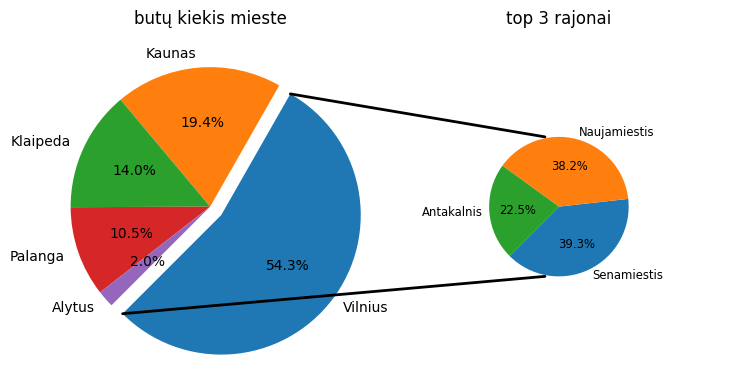

In [34]:
# make figure and assign axis objects
fig = plt.figure(figsize=(9, 5.0625))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)

# large pie chart parameters
ratios = butukiekismiesteDF['count']
labels = butukiekismiesteDF['miestas']
explode = [0.1, 0, 0, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]+45
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, explode=explode)

# small pie chart parameters
ratios = vilniusbutukiekistop3DF['count']
labels = vilniusbutukiekistop3DF['rajonas']
width = .2

ax2.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, radius=0.5, textprops={'size': 'smaller'})

ax1.set_title('butų kiekis mieste')
ax2.set_title('top 3 rajonai')

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(- width / 2, .5), xyB=(x, y),
                      coordsA="data", coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(- width / 2, -.5), xyB=(x, y), coordsA="data",
                      coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()

In [35]:
print(df['amzius'])

0        1.0
1       21.0
2       44.0
3       16.0
4       55.0
        ... 
5689    42.0
5690    52.0
5691    49.0
5692    33.0
5693    61.0
Name: amzius, Length: 5694, dtype: float64
